# Imports

In [3]:
from glob import glob
import pandas as pd
import numpy as np
from numpy import ma
import mat73
from scipy import stats
import matplotlib.pyplot as plt
from IPython.display import display as disp
from os.path import basename
import subprocess
from statsmodels.stats.anova import AnovaRM
# %config Completer.use_jedi = True

# Functions

In [66]:
def true_meshgrid(*arr):
    if len(arr) == 1:
        return np.array(arr[0])[:, None]
    return np.swapaxes(np.array(np.meshgrid(*arr)), 1, 2).reshape(len(arr), -1).T

import scipy.io as spio

from matplotlib import transforms as mtrans
from matplotlib.colors import rgb2hex

def transform_same_lines(ax_obj, fig, shift):
    children = ax_obj.get_children()
    colors = []
    for i in children:
        if not hasattr(i, 'get_color'):
            colors.append('')
            continue
        
        if isinstance(i.get_color(), str):
            temp = i.get_color()
        else:
            temp = rgb2hex(i.get_color()[0])
        
        if temp[0] == '#':
            colors.append(temp)
        else:
            colors.append('')
    
    colors_set = list(set(colors) ^ {''})
    colors = np.array(colors)
    children_arr = np.array(children)
    
    for ind, color in enumerate(colors_set):
        temp = children_arr[colors==color].tolist()
        tr = mtrans.offset_copy(ax_obj.transData, fig=fig, x=ind*shift, y=0., units='points')
        for obj in temp: 
            obj.set_transform(tr)

def _loadmat(filename):
    '''
    this function should be called instead of direct spio.loadmat
    as it cures the problem of not properly recovering python dictionaries
    from mat files. It calls the function check keys to cure all entries
    which are still mat-objects
    '''
    data = spio.loadmat(filename, struct_as_record=False, squeeze_me=True)
    ks = '__header__', '__version__', '__globals__'
    for k in ks:
        data.pop(k)
    return _check_keys(data)

def _check_keys(dict):
    '''
    checks if entries in dictionary are mat-objects. If yes
    todict is called to change them to nested dictionaries
    '''
    for key in dict:
        if isinstance(dict[key], spio.matlab.mio5_params.mat_struct):
            dict[key] = _todict(dict[key])
        elif isinstance(dict[key], np.ndarray):
            for ind, obj in enumerate(dict[key]):
                dict[key][ind] = _todict(obj)
    return dict        

def _todict(matobj):
    '''
    A recursive function which constructs from matobjects nested dictionaries
    '''
    dict = {}
    for strg in matobj._fieldnames:
        elem = matobj.__dict__[strg]
        if isinstance(elem, spio.matlab.mio5_params.mat_struct):
            dict[strg] = _todict(elem)
        else:
            dict[strg] = elem
    return dict

def _redefine(struct):
    struct['label'] = np.squeeze(struct['label']).tolist()
    time = struct['time']
    trial = struct['trial']
    lens = [t.shape[0] for t in time]
    minlen = min(lens)
    for ind, (ti, tr) in enumerate(zip(time, trial)):
        struct['trial'][ind] = tr[..., :minlen]
        struct['time'][ind] = ti[:minlen]
    struct['time'] = np.array(np.array(struct['time']).tolist(), dtype=np.float64)
    struct['trial'] = np.array(np.array(struct['trial']).tolist(), dtype=np.float64)

def recursive_redefine(struct):
    if isinstance(struct, list) or isinstance(struct, np.ndarray):
        for obj in struct:
            recursive_redefine(obj)
    if isinstance(struct, dict):
        if (struct.get('trial') is not None) and (struct.get('time') is not None) and (struct.get('fsample') is not None):
            if isinstance(struct['time'], list):
                _redefine(struct)
            elif struct['trial'].dtype == np.object:
                _redefine(struct)
            
            if len(struct['trial'].shape) == 2:
                struct['trial'] = struct['trial'][np.newaxis, :, :]
            
            if len(struct['time'].shape) == 1:
                struct['time'] = np.tile(struct['time'], (struct['trial'].shape[0], 1))

        else:
            for k, v in struct.items():
                recursive_redefine(v)

def loadmat(fname):
    try:
        return mat73.loadmat(fname)
    except TypeError:
        return _loadmat(fname)
    
def save_masked(name, arr):
    temp = np.array(arr)
    temp[arr.mask] *= np.nan
    np.save(name, temp)
    
def load_masked(name):
    temp = np.load(name)
    return ma.array(temp, mask=np.isnan(temp))

def norm(a):
    return (a - np.nanmin(a))/(np.nanmax(a) - np.nanmin(a))
    
def local_mins(sig):
    sig_len = sig.shape[-1]
    local_min_points_mask = np.diff((np.diff(sig) < 0).astype(int)) < 0
    local_min_points_inds = np.r_[2:sig_len][local_min_points_mask]
    local_min_points_values = sig[local_min_points_inds]
    return local_min_points_inds, local_min_points_values

def local_maxes(sig):
    sig_len = sig.shape[-1]
    local_min_points_mask = np.diff((np.diff(sig) < 0).astype(int)) > 0
    local_min_points_inds = np.r_[2:sig_len][local_min_points_mask]
    local_min_points_values = sig[local_min_points_inds]
    return local_min_points_inds, local_min_points_values

import itertools

def create_shape(obj, hard=False):
    if hasattr(obj, '__len__'):
        if len(obj) == 0:
            return [0]
        if not hard:
            if not hasattr(obj[0], '__len__'):
                return [len(obj)]
        lens = [create_shape(i) for i in obj]
        pure_lens = [i for i in lens if i is not None]
        depths = []
        if len(pure_lens) != 0:
            depths = np.array(list(itertools.zip_longest(*pure_lens, fillvalue=0))).max(axis=-1).tolist()
        obj_len = len(obj)
        temp = [len(obj)] + depths
        return [i for i in temp if i != 0]
    
def marray_from_lists(obj):
    shape = np.array(create_shape(obj))
#     print(shape)
    ndims = len(shape)
    if ndims == 1:
        return ma.array(obj)
    else:
        return _marray_from_lists(obj, shape, 0)
    
def _marray_from_lists(obj, shape, depth):
    ndims = len(shape)
    if depth == ndims - 1:
        if hasattr(obj, '__len__'):
            pass # для учтения кейса
        else:
            if obj is not None:
                obj = [obj]
            else:
                temp = ma.empty(shape[depth])
                temp.mask = True
                return temp
        ntrail = shape[depth] - len(obj)
        trail = ma.empty(ntrail)
        trail.mask = True
        temp = ma.array(obj)
        return ma.concatenate((obj, trail))
    else:
        if not hasattr(obj, '__len__'):
            temp = ma.empty(shape[depth:])
            if obj is not None:
                mask = np.ones(shape[depth:]).flatten()
                temp = ma.empty(shape[depth:]).flatten()
                mask[0] = 0
                temp[0] = obj
                temp.mask = mask
                temp = temp.reshape(shape[depth:])
            else:
                temp.mask = True
            return temp
        else:
            trail_shape = shape[depth:].copy()
            trail_shape[0] -= len(obj)
#             print(trail_shape, shape)
            trail = ma.empty(trail_shape)
            trail.mask = True
            temp = ma.stack([_marray_from_lists(i, shape, depth + 1) for i in obj])
            temp = ma.concatenate((temp, trail))
            return temp
        
def allbut(*names, levels):
    names = set(names)
    return [item for item in levels if item not in names]

def get_MANOVA_table(data, sub_f, factors, var_names):
    if len(data.shape) != sub_f + 2:
        data = data.copy()[..., None]
    assert data.shape[-1] == len(var_names)
    assert sub_f == len(factors.keys())
    for i, v in enumerate(factors.values()):
        assert data.shape[i] == len(v)
    
    sub_n = data.shape[sub_f]
    subs = np.arange(1, sub_n + 1, dtype=int).tolist()
    factors_raw = true_meshgrid(*([subs] + [v for v in factors.values()])).tolist()
    factor_names = list(factors.keys())
    cols = ['Subject'] + factor_names + var_names
    
    temp = np.rollaxis(data, sub_f).reshape(-1, len(var_names)).tolist()
    
    data_raw = [a + b for a,b in zip(factors_raw, temp)]
    res_df = pd.DataFrame(data_raw, columns=cols)
    return res_df

def plot_jasp(data, x, line=None, plots=None, errors=True, var=None, kind='line', sharey=False, scale=(1, 1), inverse_orient=False):
    limity = (None, None)
    scalemin, scalemax = scale
    if sharey:
        limity = data.min().tolist()[-1]/scalemin, data.max().tolist()[-1]/scalemax
    if plots is not None:
        ngroups = data.groupby(plots).ngroups
        cols = int(np.sqrt(ngroups))
        rows = int(np.ceil(ngroups/cols))
        if inverse_orient:
            cols, rows = rows, cols
        fig, axes = plt.subplots(nrows=rows, ncols=cols, figsize=(6.4*cols, 4.8*rows))
        axes = np.array(axes).flatten().tolist()
        for (group_name, group), ax in zip(data.groupby(plots), axes):
            group_name = [group_name] if not isinstance(group_name, tuple) else group_name
            plots_list = [plots] if not hasattr(plots, '__iter__') else plots
            title = '; '.join([': '.join(i) for i in zip(plots_list, group_name)])
            _plot_jasp(group, x, line, title, ax=ax, errors=errors, kind=kind, sharey=limity, var=var)
    else:
        fig, ax = plt.subplots(1, 1)
        _plot_jasp(data, x, line, ax=ax, var=var)
    return fig
    
    
def _plot_jasp(data, x, line=None, title=None, subplots=False, ax=None, errors=True, kind='line', sharey=(None, None), var=None):
    groups = [x]
    groups.append(line) if line is not None else None
    means = data.groupby(groups).mean().unstack(level=x).T.droplevel(0)
    errors = data.groupby(groups).sem().unstack(level=x).T.droplevel(0) if errors else None
    kwargs = {}
    if errors is not None:
        kwargs['capsize'] = 8
    ax = means.plot(kind=kind, yerr=errors, title=title, ax=ax, ylim=sharey, **kwargs)
    xticks = list(means.index)
#     print(xticks)
    if len(xticks) == 2:
        ticks = ax.get_xticklabels()
#         print(ticks)
        ticks[-2].set_text(xticks[-1])
        ax.set_xticklabels(ticks)
#     print()
    ax.grid()
    fig = ax.figure
    transform_same_lines(ax, fig, 10) if kind =='line' else None

# FNC Data loading

In [5]:
dfs = {}
datas = {}
norms = ['absolute', '1d', 'relative', 'relative1d']
coef_types = ['ClustCoef', 'Eglob']
exclude = {'__header__', '__version__', '__globals__'}
table_labels = true_meshgrid(norms, coef_types)
for norm, coef_type in table_labels:
    print(norm, coef_type)
    test = []
    days = len(glob(f'data/fnc_{norm}_norm/{coef_type}*'))
    for fname in glob(f'data/fnc_{norm}_norm/{coef_type}*'):
        mat = spio.loadmat(fname)
        field = list(set(mat.keys()) - exclude)[0]
        for i in range(15):
            if i == 9:
                test += np.full(2*2*3*2*2, np.nan).tolist()
                continue
            for j in range(4):
                for k in range(3):
                    test += [i[0][0] for i in mat[field][i, j][0, 0][k][0][0]]

    data = np.array(test).reshape(days,    15,   2,     2,        3,     2,      2)
    #                            'day' 'sub' 'cond' 'session' 'band' 'zone', 'side'
    days = [f'D{i+1}' for i in range(days)]
    conds = ['Pre', 'Post']
    sessions = ['Im1', 'Im2']
    bands = ['Theta', 'Alpha', 'Beta']
    zones = ['BA4', 'BA6']
    sides = ['Left', 'Right']

    labels = true_meshgrid(days, conds, sessions, bands, zones, sides)
    labels_dict = {
        'Day': days,
        'Condition': ['Baseline', 'Post'],
        'Session': sessions,
        'Band': bands,
        'Zone': zones,
        'Side': sides,
    }
    # df = get_RM_ANOVA_table(data[:, :, :, ...], 1, labels)
    # df.to_csv(f'tables/{coef_type}_{norm}_norm_TMS.csv', index=False)
    temp_data = np.rollaxis(data[:, :, :, ...][..., None], 1, -1)
    df = get_MANOVA_table(temp_data, 6, labels_dict, ['Coef'])
    dfs[coef_type] = {} if dfs.get(coef_type) is None else dfs[coef_type]
    dfs[coef_type][norm] = df.query("Subject != '10'")
    datas[coef_type] = {} if datas.get(coef_type) is None else datas[coef_type]
    datas[coef_type][norm] = {'data': data, 'groups': labels}

absolute ClustCoef
absolute Eglob
1d ClustCoef
1d Eglob
relative ClustCoef
relative Eglob
relative1d ClustCoef
relative1d Eglob


In [6]:
# files = sorted(glob('../power_sfr/ClustPow_Norm_by_1stDay/*'))
# filenames = [basename(i) for i in files]
# f = open(files[0])
# data = np.stack([np.array([i.split() for i in open(file).readlines()]).astype(float) for file in files])
# data[data == 0] = np.nan
# data = data.reshape(2, 3, 2, 2, 15, 2, 2, 1)
# data = np.transpose(data, [0, 1, 2, 3, 5, 6, 4, 7])
# conds = {
#     'Condition': ['Baseline', 'Post'],
#     'Band': ['Alpha', 'Beta', 'Theta'],
#     'Zone': ['BA4', 'BA6'],
#     'Side': ['Left', 'Right'],
#     'Day': ['D1', 'D2'],
#     'Session': ['Im1', 'Im2']
# }
# tms_power = get_MANOVA_table(data, 6, conds, ['Power']).query('Subject != "10"')
# tms_power.to_csv('../power_sfr/TMS_CLUST_POWER_1D_NORM.csv', index=False)
tms_power = pd.read_csv('../power_sfr/TMS_CLUST_POWER_1D_NORM.csv')

In [7]:
tms_power_old = pd.read_csv('../power_sfr/tms_all_ma.csv')
tms_power_old['Zone'] = 'BA' + tms_power_old['Zone'].astype(str)
tms_power_old['Subject'] = tms_power_old['Subject'].astype('category')

In [110]:
b = tms_power_old.set_index(['Subject', 'Side','Band', 'Zone', 'Day','Session']).query('Condition == "Post"').drop(columns='Condition').dropna()
a = tms_power_old.set_index(['Subject', 'Side','Band', 'Zone', 'Day','Session']).query('Condition == "Base"').drop(columns='Condition').dropna()
tms_count = a > b
tms_count = tms_count.reset_index()
tms_count = tms_count.groupby(['Side','Band', 'Zone', 'Day','Session']).mean().reset_index()


# depvar = 'Power'
# subject = 'Subject'
# cols = list(set(tms_count.columns) - set([depvar, subject]))
# res = AnovaRM(data=tms_count, depvar=depvar, subject=subject, within=cols, aggregate_func=np.mean).fit()
# res_sum = res.summary().tables[0].query('`Pr > F` < 0.06')
# disp(res_sum)


In [100]:
tms_count.query('Zone == "BA6"')

,Side,Band,Zone,Day,Session,Power
4,L,Alpha,BA6,D1,Im1,0.428571
5,L,Alpha,BA6,D1,Im2,0.642857
6,L,Alpha,BA6,D2,Im1,0.285714
7,L,Alpha,BA6,D2,Im2,0.428571
12,L,Beta,BA6,D1,Im1,0.785714
13,L,Beta,BA6,D1,Im2,0.928571
14,L,Beta,BA6,D2,Im1,0.857143
15,L,Beta,BA6,D2,Im2,0.785714
20,L,Theta,BA6,D1,Im1,0.642857
21,L,Theta,BA6,D1,Im2,0.714286


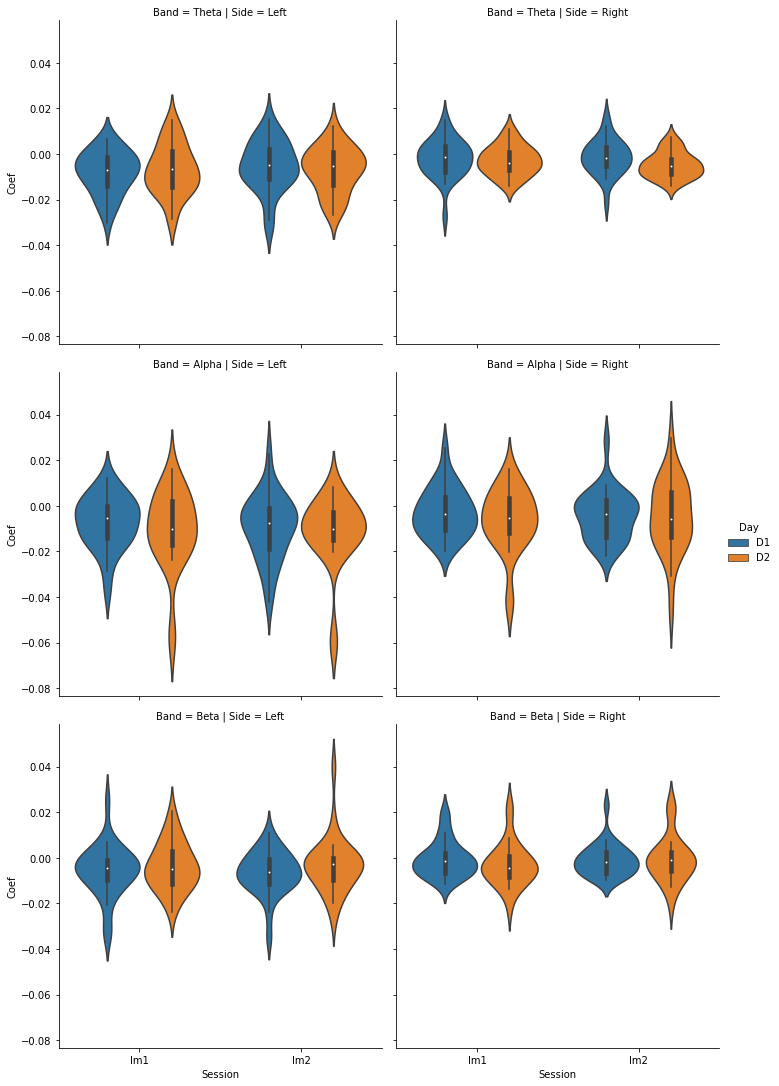

In [51]:
import seaborn as sns
fig = sns.catplot(x='Session', y='Coef', hue='Day', col='Side', row='Band', data=dfs['ClustCoef']['absolute'].query('Zone == "BA6"'), kind='violin')

In [95]:
import matplotlib.pyplot as plt
test = pd.DataFrame()
n = dfs['ClustCoef']['absolute']['Coef'].size
labels = np.repeat(true_meshgrid(['Cluster coefficient', 'Eglob'], ['Absolute', 'Relative']), n, axis=0)
clab = pd.DataFrame(labels[:1344], columns=['Type', 'Norm'])
clre = pd.DataFrame(labels[1344:1344*2], columns=['Type', 'Norm'])
egab = pd.DataFrame(labels[1344*2:1344*3], columns=['Type', 'Norm'])
egre = pd.DataFrame(labels[1344*3:1344*4], columns=['Type', 'Norm'])
pd.concat( [dfs['ClustCoef']['absolute'], clab], join='outer', )
# a = dfs['ClustCoef']['absolute'].reset_index()['Coef'].to_numpy()
# b = dfs['ClustCoef']['relative'].reset_index()['Coef'].to_numpy()
# c = dfs['Eglob']['absolute'].reset_index()['Coef'].to_numpy()
# d = dfs['Eglob']['relative'].reset_index()['Coef'].to_numpy()
# test = np.stack([a, b, c, d]).reshape(2, 2, -1)
# test = test.reshape(-1, 1)
# test = np.hstack([labels, test])
# test = pd.DataFrame(test, columns=['Coef', 'Norm', 'Value'])
# test['Value'] = test['Value'].astype(float)

# test['Value'] = dfs['ClustCoef']['absolute']['Coef'].reset_index()
# test['Coefficient'] = 'Cluster coefficient'
# test['Norm'] = 'Absolute'
# test['Cluster Relative'] = dfs['ClustCoef']['relative']['Coef'].reset_index()
# test['Eglob Absolute'] = dfs['Eglob']['absolute']['Coef'].reset_index()
# test['Eglob Relative'] = dfs['Eglob']['relative']['Coef'].reset_index()
# sns.displot(test, x="Value", col='Coef', row='Norm', kind='kde', common_norm=False, facet_kws=dict(sharey=False, sharex=False))


,Subject,Day,Condition,Session,Band,Zone,Side,Coef,Type,Norm
0,1,D1,Baseline,Im1,Theta,BA4,Left,-0.004052,NaN,NaN
1,1,D1,Baseline,Im1,Theta,BA4,Right,0.004320,NaN,NaN
2,1,D1,Baseline,Im1,Theta,BA6,Left,-0.000725,NaN,NaN
3,1,D1,Baseline,Im1,Theta,BA6,Right,0.004814,NaN,NaN
4,1,D1,Baseline,Im1,Alpha,BA4,Left,-0.010996,NaN,NaN
...,...,...,...,...,...,...,...,...,...,...
2683,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,Cluster coefficient,Absolute
2684,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,Cluster coefficient,Absolute
2685,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,Cluster coefficient,Absolute
2686,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,Cluster coefficient,Absolute


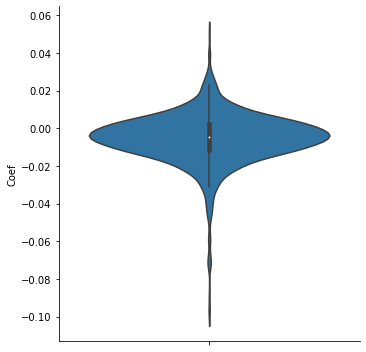

In [55]:
sns.catplot(y='Coef', data=dfs['ClustCoef']['absolute'], kind='violin')

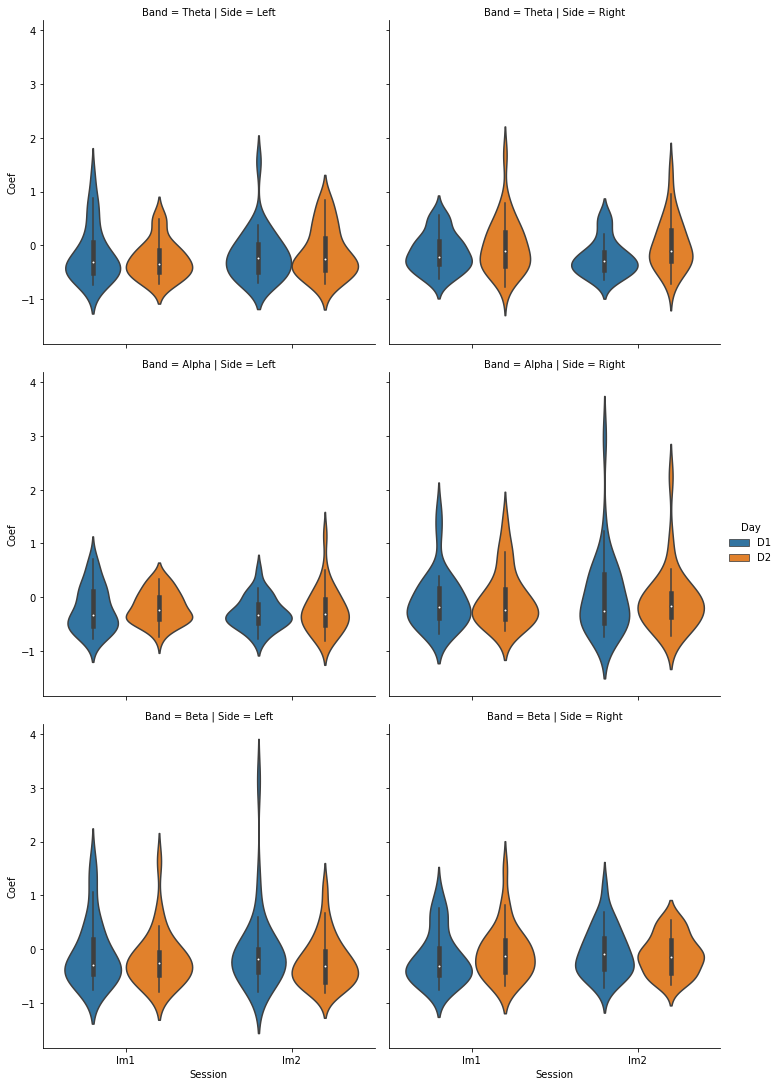

In [52]:
import seaborn as sns
sns.catplot(x='Session', y='Coef', hue='Day', col='Side', row='Band', data=dfs['ClustCoef']['relative'].query('Zone == "BA6"'), kind='violin')


In [66]:
tms_power_old.query('Condition == "Base"').drop(columns='Condition')

,Subject,Side,Band,Zone,Day,Session,Power
0,1,L,Theta,BA6,D1,Im1,-0.002590
1,1,L,Theta,BA6,D1,Im2,-0.001740
2,1,L,Theta,BA6,D2,Im1,-0.000168
3,1,L,Theta,BA6,D2,Im2,0.001010
4,1,L,Theta,BA4,D1,Im1,-0.000598
...,...,...,...,...,...,...,...
1291,14,R,Beta,BA6,D2,Im2,-0.001300
1292,14,R,Beta,BA4,D1,Im1,-0.000235
1293,14,R,Beta,BA4,D1,Im2,-0.000275
1294,14,R,Beta,BA4,D2,Im1,-0.000291


array([<AxesSubplot:xlabel='Band,Session'>,
       <AxesSubplot:xlabel='Band,Session'>], dtype=object)

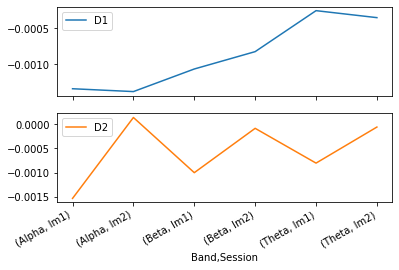

In [31]:
def apply(df):
    return df.groupby(['Day', 'Session']).mean()[['Power']].unstack(level='Session').T.droplevel(0)
tms_power.groupby(['Band']).apply(apply).plot(subplots=True)# .groupby(['Day', 'Session']).mean()[['Power']].unstack(level='Session').T.droplevel(0)

In [44]:
tms_power.head()

,Subject,Condition,Band,Zone,Side,Day,Session,Power
0,1,Baseline,Alpha,BA4,Left,D1,Im1,0.005064
1,1,Baseline,Alpha,BA4,Left,D1,Im2,0.004107
2,1,Baseline,Alpha,BA4,Left,D2,Im1,0.003242
3,1,Baseline,Alpha,BA4,Left,D2,Im2,0.005230
4,1,Baseline,Alpha,BA4,Right,D1,Im1,0.003240


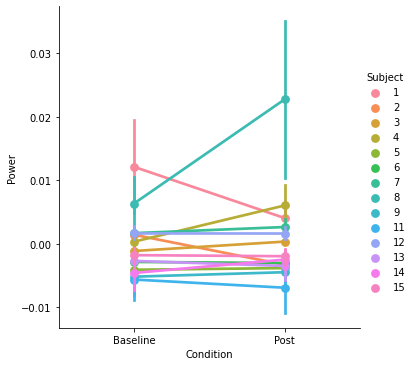

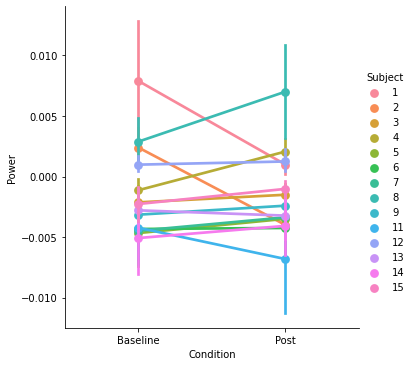

In [125]:
# tms_power.groupby(['Side', 'Zone', 'Day', 'Session']).mean()[['Power']].unstack(level=['Day', 'Session']).plot(subplots=True, rot=90, figsize=(9, 7), layout=(2, 2))
import seaborn as sns
a = tms_power.query('Day == "D2" and Session == "Im2" and Band == "Alpha"')
b = tms_power.query('Day == "D2" and Session == "Im1" and Band == "Alpha"')
sns.catplot(x='Condition', y='Power', hue='Subject', kind='point', data=a)
sns.catplot(x='Condition', y='Power', hue='Subject', kind='point', data=b)

In [148]:
np.std([1, 0, 0, 1, 0, 1, 1, 0, 0, 0, 0])
np.mean([1, 0, 0, 1, 0, 1, 1, 0, 0, 0, 0])

0.36363636363636365

CompletedProcess(args=['osascript', '-e', 'set the clipboard to (read (POSIX file "temp.jpg") as JPEG picture)'], returncode=0)

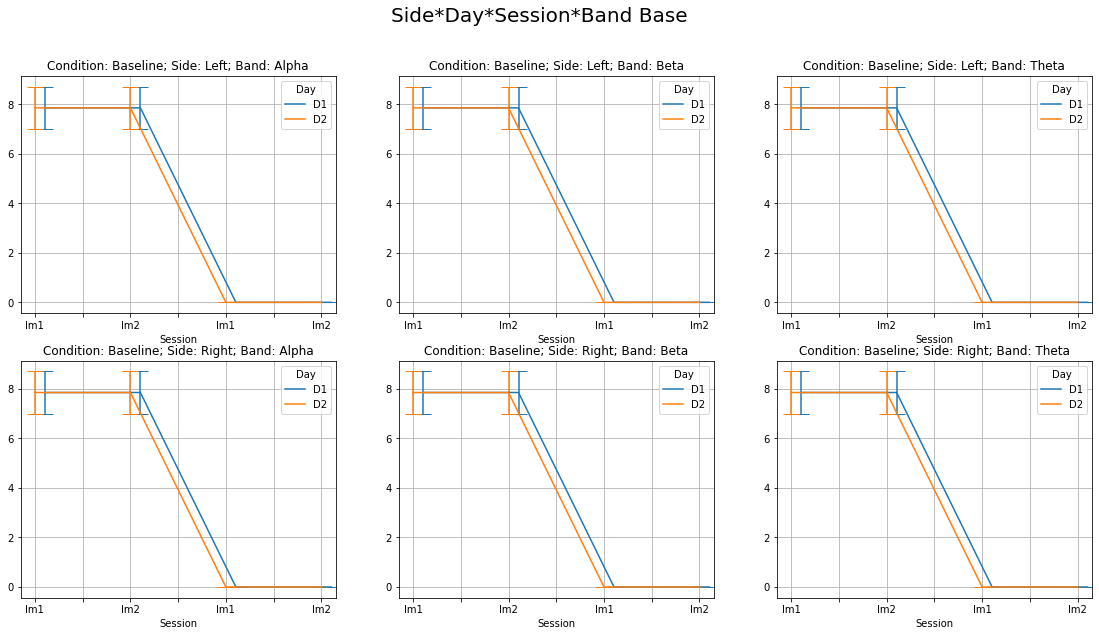

In [10]:
data = tms_power
col = data.columns[0]
x = 'Session'
line = 'Day'
plots = ['Condition', 'Side', 'Band']
# plots = None
inverse_orient = True

title = 'Side*Day*Session*Band Base'

query = 'Condition == "Baseline"' #and Zone == "BA6" and Side == "L"'
# query = f"{col}.isnull() or {col}.notnull()"
fig = plot_jasp(data.query(query), x, line=line, plots=plots, sharey=False, scale=(8, 1000), inverse_orient=inverse_orient);
# fig.tight_layout()
fig.suptitle(title, fontsize=20)
fig.savefig('temp.jpg')
subprocess.run(["osascript", "-e", 'set the clipboard to (read (POSIX file "temp.jpg") as JPEG picture)'])

In [34]:
data = dfs['Eglob']['absolute']
depvar = 'Coef'
subject = 'Subject'
cols = list(set(data.columns) - set([depvar, subject]))
res = AnovaRM(data=data, depvar=depvar, subject=subject, within=cols, aggregate_func=np.median).fit()
res_sum = res.summary().tables[0].query('`Pr > F` < 0.06')
disp(res_sum)
# res.summary()

,F Value,Num DF,Den DF,Pr > F
Band,3.239847,2.0,26.0,0.055424
Side,6.499297,1.0,13.0,0.024221
Zone,4.624932,1.0,13.0,0.050904
Session:Day:Band,3.175076,2.0,26.0,0.058380
Band:Side:Zone,4.186955,2.0,26.0,0.026526
Session:Day:Side:Condition:Zone,4.692538,1.0,13.0,0.049467


In [32]:
np.unique(dfs['ClustCoef']['absolute']['Subject'].to_numpy())

array(['1', '11', '12', '13', '14', '15', '2', '3', '4', '5', '6', '7',
       '8', '9'], dtype=object)

In [28]:
df = postHocTtest(tms_power_old, depvar='Power', effects=['Side', 'Zone'], includes=['Day', 'Session', 'Band', 'Condition'], query=query, average_unused=True, agg='mean')
# df.style.apply(lambda x: [f"background-color: #00ff00{hex(int(255*v))[2:]}" 
#                           if (i >= 1 and v < 0.05)
#                           else "" for i, v in enumerate(x)], axis = 1)
df.style.background_gradient(subset=['P value', 'Holmes corr'], cmap='Reds_r', vmin=0., vmax=0.1)
# df.query(' < 0.05')

In [48]:
# query = 'Zone == "Condition == "Post"'
query = None
data = dfs['Eglob']['relative']
depvar = 'Coef'
# print(query)
df = postHocTtest(data, depvar=depvar, effects=['Day', 'Session'], includes=['Band', 'Zone', 'Side', 'Condition'], query=query, average_unused=True, agg='mean')
# df.style.apply(lambda x: [f"background-color: #00ff00{hex(int(255*v))[2:]}" 
#                           if (i >= 1 and v < 0.05)
#                           else "" for i, v in enumerate(x)], axis = 1)
df.query('`P value` < 0.0505').style.background_gradient(subset=['P value', 'Holmes corr'], cmap='Reds_r', vmin=0., vmax=0.1)



In [2]:
query = None
# print(query)
df = postHocTtest(dfs['Eglob']['absolute'], depvar='Coef', effects=['Day', 'Session'], includes=['Band', 'Zone', 'Side', 'Condition'], query=query, average_unused=True, agg='mean')
# df.style.apply(lambda x: [f"background-color: #00ff00{hex(int(255*v))[2:]}" 
#                           if (i >= 1 and v < 0.05)
#                           else "" for i, v in enumerate(x)], axis = 1)
df.style.background_gradient(subset=['P value', 'Holmes corr'], cmap='Reds_r', vmin=0., vmax=0.1)

NameError: name 'dfs' is not defined

In [4]:
from statsmodels.stats.anova import AnovaRM
coef_type = 'ClustCoef'
norm = 'relative'
for coef_type in coef_types:
    print(coef_type, norm)
    data = dfs[coef_type][norm]
    res = AnovaRM(data=data, depvar='Coef', subject='Subject', within=list(labels_dict.keys()), aggregate_func=np.mean).fit()
    res_sum = res.summary().tables[0].query('`Pr > F` <= 0.05')
    disp(res_sum)

ClustCoef relative


,F Value,Num DF,Den DF,Pr > F
Day:Session:Band,3.718946,2.0,26.0,0.037979
Day:Condition:Session:Zone,13.414319,1.0,13.0,0.002868
Day:Band:Zone:Side,3.541074,2.0,26.0,0.043645


Eglob relative


,F Value,Num DF,Den DF,Pr > F
Day:Session:Band,4.228616,2.0,26.0,0.025704


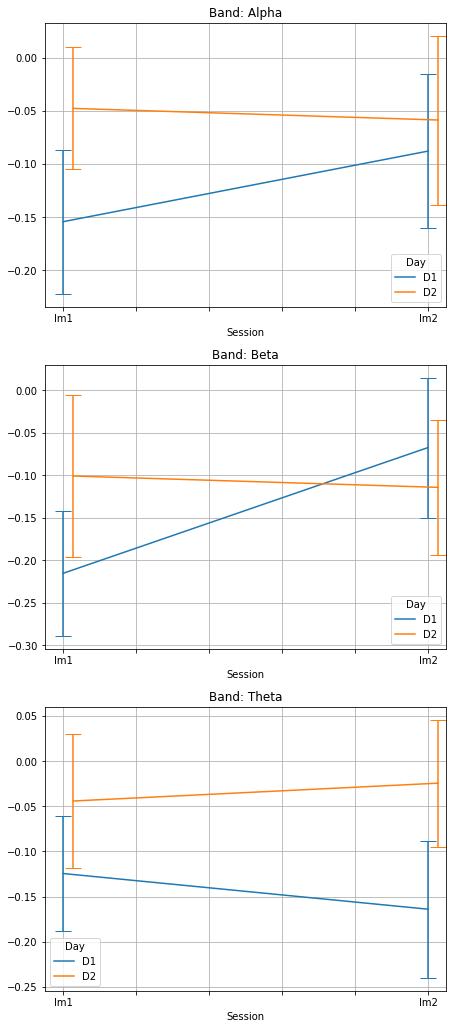

In [172]:
data = dfs["ClustCoef"]['relative']
x = 'Session'
line = 'Day'
plots = ['Band']
fig = plot_jasp(data.query('Condition == "Post"'), x, line=line, plots=plots, sharey=False, scale=(8, 1000));
fig.tight_layout()
# fig.savefig(f'TMS_{coef_type}_{norm}_@{x}_{line}_{"_".join(plots)}@.png')

In [41]:
from itertools import compress, combinations
from scipy import stats
from scipy.stats import rankdata

def unique_labels(df, columns):
    df_columns = df.columns
    assert isinstance(columns, list)
    assert len(set(columns) - set(df_columns)) == 0, "Missing columns"
    labels = [np.unique(i).tolist() for i in df[columns].to_numpy().T]
    return {k:v for k, v in zip(columns, labels)}

def holmes_correction(vals, crit=0.05):
    inds = np.argsort(vals)
    corr_mul = np.arange(len(vals))[::-1] + 1
    return vals < crit/corr_mul[inds]

def fdr(p_vals):
    ranked_p_values = rankdata(p_vals)
    fdr = p_vals * len(p_vals) / ranked_p_values
    fdr[fdr > 1] = 1

    return fdr

def postHocTtest(df, depvar=None, subject='Subject', effects=None, includes=[], average_unused=True, query=None, agg = 'mean'):
    temp = df.copy() if query is None else df.query(query)
    columns = temp.columns
    assert len(set(effects) - set(columns)) == 0, "Missing effects"
    assert subject in columns, "Missing subject column"
    assert len(set(includes) - set(columns)) == 0, "Missing includes"
    assert depvar in columns, 'Missing depvar'

    if average_unused:
        if agg == 'mean':
            temp = temp.groupby([subject] + effects + includes).mean().reset_index()
        else:
            temp = temp.groupby([subject] + effects + includes).median().reset_index()
    labels_dict = unique_labels(temp, effects)
    if len(includes) != 0:
        labels_dict.update(unique_labels(temp, includes))
    mask = [True if i in effects else False for i in labels_dict.keys()]
    mask_conds = [True for i in range(len(mask))]
    inds = compress(range(len(mask)), mask)
    
    labels = [i for i in labels_dict.keys()]
    cc = [i for i in labels_dict.values()]
    used_cc = compress(cc, mask)
    stat = []
    ps = []
    index = []
    for ind, c in zip(inds, used_cc):
        mask_conds[ind] = False
        cc_temp = list(compress(cc, mask_conds))
        # print(mask_conds)
        # print(cc)
        # print(list(cc_temp))
        for x1, x2 in combinations(c, 2):
            if len(cc_temp) > 1:
                mesh = true_meshgrid(*cc_temp).tolist()
            else:
                mesh = np.array(cc_temp).T.tolist()
            for label in mesh:
                l1, l2 = label.copy(), label.copy()
                l1.insert(ind, x1)
                l2.insert(ind, x2)
                query_a = " and ".join([f'{cond_name} == "{cond}"' for cond_name, cond in zip(labels, l1)])
                query_b = " and ".join([f'{cond_name} == "{cond}"' for cond_name, cond in zip(labels, l2)])
                a = temp.query(query_a)[depvar]
                b = temp.query(query_b)[depvar]
                pval, statistic = stats.ttest_rel(a, b, nan_policy='omit').pvalue, stats.ttest_rel(a, b, nan_policy='omit').statistic
                stat.append(statistic), ps.append(pval)
                index.append([labels[ind]] + label + [x1, x2])
        mask_conds[ind] = True
    res_df = pd.DataFrame([stat, ps]).T
    # print(index)
    res_df.index = pd.MultiIndex.from_tuples(index)
    res_df.columns = ['Statistic', 'P value']
    res_df['Holmes corr'] = fdr(res_df['P value'])
    res_df.index.names = ['Effect'] + [i for i in range(len(label))] + ['A', 'B']
    # res_df.style.apply(lambda x: ["background: red" if v > 0.05 and if  else "" for v in x], axis = 1)
    res_df
    return res_df

In [183]:
df = postHocTtest(dfs["ClustCoef"]['relative'], effects=['Day', 'Session'], includes=['Band'])
df.style.apply(lambda x: ["background-color: red" 
                          if (i >= 1 and v < 0.05)
                          else "" for i, v in enumerate(x)], axis = 1)

In [182]:
rankdata([4, 2])

array([2., 1.])